## 3. Estimating and identifying risk

In [1]:
# Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.stats import norm, anderson

In [2]:
#upload
tickers=['GS','C','JPM','BAC']
start_date='2005-01-01'
end_date='2010-12-31'

In [3]:
df = web.DataReader(tickers,'yahoo',start=start_date,end=end_date)
stocks=df['Close']

In [4]:
stock_returns=stocks.pct_change().dropna()
weight=[0.25,0.25,0.25,0.25]

In [5]:
portfolio_losses=stock_returns@weight

Parameter estimation: Normal <br>
Is a Normal distribution a good fit? You'll test this with the scipy.stats.anderson Anderson-Darling test. If the test result is statistically different from zero, this indicates the data is not Normally distributed. You'll address this in the next exercise.

In [6]:
# Fit portfolio losses to the Normal distribution
params = norm.fit(portfolio_losses)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = norm.ppf(0.95, *params)
print("VaR_95, Normal distribution: ", VaR_95)

# Test the data for Normality
print("Anderson-Darling test result: ", anderson(portfolio_losses))

VaR_95, Normal distribution:  0.0555493663974691
Anderson-Darling test result:  AndersonResult(statistic=92.92325946879873, critical_values=array([0.574, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


Parameter estimation: Skewed Normal <br>
Now you'll parametrically estimate the 95% VaR of a loss distribution fit using scipy.stats's skewnorm skewed Normal distribution. This is a more general distribution than the Normal and allows losses to be non-symmetrically distributed. We might expect losses to be skewed during the crisis, when portfolio losses were more likely than gains.

In [7]:
# Import the skew-normal distribution and skewness test from scipy.stats
from scipy.stats import skewnorm, skewtest

# Test the data for skewness
print("Skewtest result: ", skewtest(portfolio_losses))

# Fit the portfolio loss data to the skew-normal distribution
params = skewnorm.fit(portfolio_losses)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = skewnorm.ppf(0.95, *params)
print("VaR_95 from skew-normal: ", VaR_95)

Skewtest result:  SkewtestResult(statistic=16.116236746361235, pvalue=1.9619906941433276e-58)
VaR_95 from skew-normal:  0.05718202295457746


Historical Simulation <br>

In [8]:
# Find the historical simulated VaR estimates
#portfolio_losses = np.array([ x.dot(weight) for x in stock_returns])

VaR_95 = [np.quantile(x, 0.95) for x in portfolio_losses]

# Display the VaR estimates
#print("VaR_95, 2005-2006: ", VaR_95[0], '; VaR_95, 2007-2009: ', VaR_95[1])

#print(len(VaR_95))

Monte Carlo Simulation

In [9]:
# Calculate covariance matrix
# Mean returns of stock
mean_stock_ret=stock_returns.mean()
# Demean stock returns
demean_stock_ret = stock_returns - mean_stock_ret
# Cov matrix = (demean stock ret)T x (demean stock ret) / length(stock_returns)
cov_mat = np.transpose(demean_stock_ret)@demean_stock_ret/len(stock_returns)
#reshape mean from 1d to 4x1d
mu=mean_stock_ret.values.reshape([4,1])
print(cov_mat)

Symbols        GS         C       JPM       BAC
Symbols                                        
GS       0.000863  0.000864  0.000677  0.000828
C        0.000864  0.002125  0.001069  0.001560
JPM      0.000677  0.001069  0.001047  0.001129
BAC      0.000828  0.001560  0.001129  0.001812


In [10]:
# Initialize daily cumulative loss for the 4 assets, across N runs
N = 10
daily_loss = np.zeros(( 4, N))
# 1 day = 60*8 = 480 mins
total_steps = 480

# Create the Monte Carlo simulations for N runs
for n in range(N):
    # Compute simulated path of length total_steps for correlated returns
    correlated_randomness = cov_mat @ norm.rvs(size = (4,total_steps))
    # Adjust simulated path by total_steps and mean of portfolio losses
    steps = 1/total_steps
    minute_losses = mu * steps + correlated_randomness * np.sqrt(steps)
    daily_loss[:, n] = minute_losses.sum(axis=1)
# Generate the 95% VaR estimate
losses = weight @ daily_loss
print("Monte Carlo VaR_95 estimate: ", "{:.4f}".format(np.quantile(losses, 0.95)))

Monte Carlo VaR_95 estimate:  0.0032


# Structural Breaks <br>
Estimation techniques require stationarity <br> 
Historical: unknown stationary distribution from past data <br>
Parametric: assumed stationary distribution class <br>
Monte Carlo: assumed stationary distribution for random draws <br>

Non-stationary=>perhaps distribution changes over time <br>
Assume specific points in time for change <br>
Breakup data into sub-periods <br>
Within each sub-period,assume stationarity <br>
Structural break(s):point(s) of change <br>
Change in'trend'of average and/or volatility of data <br>


In [11]:
# Transform the daily portfolio_returns into quarterly volatility
vol_q = portfolio_losses.resample('Q').std()

# Transform daily portfolio_returns returns into quarterly minimum returns
port_q_min = portfolio_losses.resample('Q').min()

port_q_min=port_q_min.to_frame()
vol_q = vol_q.to_frame()

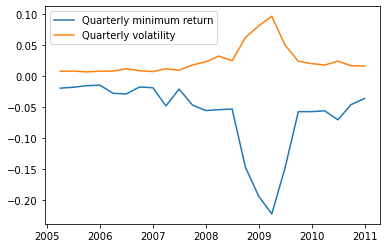

In [12]:
# Create a plot of quarterly minimum portfolio returns
plt.plot(port_q_min, label="Quarterly minimum return")

# Create a plot of quarterly mean volatility
plt.plot(vol_q, label="Quarterly volatility")

# Create legend and plot
plt.legend()
plt.show()

In [13]:
# mortgage delinquency rates downloaded from 
# https://fred.stlouisfed.org/series/DRSFRMACBS
MDR = pd.read_excel('MDR.xlsx',index_col='DATE')
#convert percent to decimals
MDR['MDR']=MDR['MDR']/100
mort_del=MDR.loc['2005-03-30':'2011-01-01']


In [63]:
#assign same indexes to MRD
mort_del.index=port_q_min.index
#reshape portfolio minimum returns to correct 2 d shape
port_q_min = np.reshape(port_q_min, (24, 1))


In [64]:
# Import the statsmodels API to be able to run regressions
import statsmodels.api as sm

# Add a constant to the regression
mort_del_const = sm.add_constant(mort_del)

# Regress quarterly minimum portfolio returns against mortgage delinquencies
result = sm.OLS(port_q_min, mort_del_const).fit()

# Retrieve the sum-of-squared residuals
ssr_total = result.ssr
print("Sum-of-squared residuals, 2005-2010: ", ssr_total)

Sum-of-squared residuals, 2005-2010:  0.05658622019124482


In [65]:
before=pd.DataFrame() 
before=mort_del.loc['2005-03-30':'2008-07-01']
before['returns']=port_q_min.loc['2005-03-30':'2008-07-01']
after=mort_del.loc['2008-07-01':]
after['returns']=port_q_min.loc['2008-07-01':]

<ipython-input-65-05b77c6446e5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before['returns']=port_q_min.loc['2005-03-30':'2008-07-01']
<ipython-input-65-05b77c6446e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after['returns']=port_q_min.loc['2008-07-01':]


In [66]:
# Add intercept constants to each sub-period 'before' and 'after'
before_with_intercept = sm.add_constant(before['MDR'])
after_with_intercept  = sm.add_constant(after['MDR'])

# Fit OLS regressions to each sub-period
r_b = sm.OLS(before['returns'], before_with_intercept).fit()
r_a = sm.OLS(after['returns'],  after_with_intercept).fit()

# Get sum-of-squared residuals for both regressions
ssr_before = r_b.ssr
ssr_after = r_a.ssr
# Compute and display the Chow test statistic, 24 datapoints - 2* 2 degree of freedom
numerator = ((ssr_total - (ssr_before + ssr_after)) / 2)
denominator = ((ssr_before + ssr_after) / (24 - 4))
print("Chow test statistic: ", numerator / denominator)

if numerator/denominator > 0:
    print("Null hypothesis is to be rejected: There is structural break.")

Chow test statistic:  21.630732386579762
Null hypothesis is to be rejected: There is structural break.


## Volatility and structural breaks
Visualizing volatility changes helps reveal possible structural break points in time series.<br> By identifying when volatility appears to change, an informed choice of break point can be made that can, in turn, be used for further statistical analysis (such as the Chow test).


You'll examine two visualizations of volatility for the investment bank portfolio from 2008 - 2009, for two available portfolio weights: weights_with_citi and weights_without_citi. These correspond, respectively, to equal-weighted portfolios with and without Citibank, which exhibited (as you saw in Chapter 1) the highest volatility of the four assets over the period.

In [90]:
# create portfolio without citibank
price_without_citi = stocks.drop(columns=['C'])
weight_no_citi = [0.333,0.333,0.334]

In [91]:
# Find the time series of returns with and without Citibank
ret_with_citi = stocks.pct_change().dropna().dot(weight)
ret_without_citi = price_without_citi.pct_change().dropna().dot(weight_no_citi)

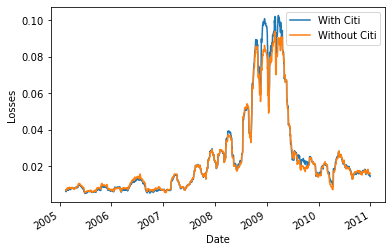

In [94]:
# Find the average 30-day rolling window volatility as the standard deviation
vol_with_citi = ret_with_citi.rolling(30).std().dropna().rename("With Citi")
vol_without_citi = ret_without_citi.rolling(30).std().dropna().rename("Without Citi")
#vol_with_citi = ret_with_citi.rolling(30).std().dropna()
#vol_without_citi = ret_without_citi.rolling(30).std().dropna()

# Combine two volatilities into one Pandas DataFrame
vol = pd.concat([vol_with_citi, vol_without_citi], axis=1)

# Plot volatilities over time
vol.plot().set_ylabel("Losses")
plt.show()

## Extreme values and backtesting
Extreme values are those which exceed a threshold and are used to determine if risk measures such as VaR are accurately reflecting the risk of loss.<br>

You'll explore extreme values by computing the 95% VaR of the equally-weighted investment bank portfolio for 2009-2010 <br>
(recall that this is equivalent to historical simulation from 2010 onwards), and then backtesting on data from 2007-2008.<br>

2009-2010 portfolio losses are available in estimate_data, from which you'll compute the 95% VaR estimate.<br>
Then find extreme values exceeding the VaR estimate, from the 2007-2008 portfolio losses in the available backtest_data.

In [95]:
backtest_data = portfolio_losses.loc['2007-01-01':'2008-12-31']
estimate_data = portfolio_losses.loc['2009-01-01':'2010-12-31']

VaR_95:  0.05173477151975916 ; Backtest:  6.349206349206349 %


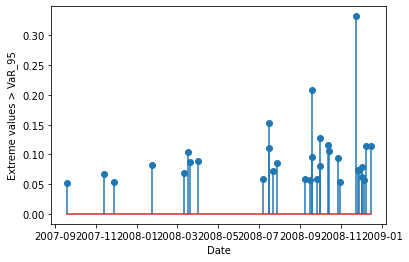

In [96]:
# Compute the 95% VaR on 2009-2010 losses
VaR_95 = np.quantile(estimate_data, 0.95)

# Use the 95% VaR to find extreme values from 2007-2008 losses
extreme_values = backtest_data[backtest_data > VaR_95]

# Compare the fraction of extreme values for 2007-2008 to the Var_95 estimate
print("VaR_95: ", VaR_95, "; Backtest: ", len(extreme_values) / len(backtest_data)*100, "%" )

# Plot the extreme values and look for clustering
plt.stem(extreme_values.index, extreme_values, use_line_collection = True)
plt.ylabel("Extreme values > VaR_95"); plt.xlabel("Date")
plt.show()